In [1]:
from collections import defaultdict
import itertools
import os
from pathlib import Path
import random
import time

from IPython.display import clear_output

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
from scipy.interpolate import interp1d
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import math
from tf_agents.replay_buffers import tf_uniform_replay_buffer

2022-10-02 21:45:02.710413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-02 21:45:02.805806: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-02 21:45:02.830628: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-02 21:45:03.276265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# tf.config.run_functions_eagerly(True)
tf.config.run_functions_eagerly(False)

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
def preprocess_images(images):
    return 2.*(images.astype("float32") / 255.) - 1.

X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

In [5]:
train_size = len(X_train)
batch_size = 32
test_size = len(X_test)

In [6]:
print(X_train.shape, y_train.shape)
print(tf.reduce_min(X_train))
print(tf.reduce_max(X_train))
print(tf.reduce_min(y_train))
print(tf.reduce_max(y_train))

(50000, 32, 32, 3) (50000, 1)


2022-10-02 21:45:05.350588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-02 21:45:05.780423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22295 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(9, shape=(), dtype=uint8)


In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(X_train)
                 .shuffle(train_size).batch(batch_size, drop_remainder=True))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test)
                .shuffle(test_size).batch(batch_size, drop_remainder=True))

In [8]:
def display_samples(samples):
    n = len(samples)
    c = 10
    r = n // c
    fig, axs = plt.subplots(r, c, figsize=(20, 20))
    for i in range(samples.shape[0]):
        ri = i // c
        ci = i % c
        axs[ri, ci].imshow(samples[i])

In [9]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs", "variational_autoencoder")

def get_tensorboard_cb(callback=keras.callbacks.TensorBoard):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return callback(run_dir)

In [14]:
class ModelSnapshotter(keras.callbacks.Callback):
    def __init__(self, frequency):
        super().__init__()
        self._frequency = frequency
        self._weights = []
    
    def on_epoch_end(self, epoch, logs):
        if epoch % self._frequency == 0:
            self._weights.append(self.model.get_weights())

In [15]:
class DCGAN(tf.keras.Model):
    def __init__(self, latent_dim, experience_buffer_max_size=None):
        super().__init__()
        self.latent_dim = latent_dim
        self.replay_buffer = None
        if experience_buffer_max_size:
            data_spec =  tf.TensorSpec([32, 32, 3], tf.float32, 'image')
            self.replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
                data_spec,
                batch_size=32,
                max_length=experience_buffer_max_size
            )
        
        self.generator = keras.models.Sequential([
            keras.layers.Dense(1024, input_shape=[latent_dim]),
            keras.layers.Reshape([1, 1, 1024]),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(512, kernel_size=5, strides=2, padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh"),
        ])
        
        self.discriminator = keras.models.Sequential([
            keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[32, 32, 3]),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(512, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
            keras.layers.BatchNormalization(),
            keras.layers.Flatten(),
            keras.layers.Dense(1),
        ])
        
        self.bce = keras.losses.BinaryCrossentropy(from_logits=True)
    
    @tf.function
    def sample(self, n_samples=10):
        noise = tf.random.normal(shape=[n_samples, self.latent_dim])
        return self.generator(noise)
    
    def compute_loss(self, x, y, y_pred, sample_weights):
        return self.bce(y, y_pred)
    
    def train_step(self, X_batch):
        X_batch_shape = tf.shape(X_batch)
        batch_size = X_batch_shape[0]
        
        noise_1 = tf.random.normal(shape=[batch_size, self.latent_dim])
        generated_images = self.generator(noise_1)
        if self.replay_buffer:
            self.replay_buffer.add_batch(generated_images)
            replay_sample = self.replay_buffer.as_dataset(single_deterministic_pass=False).take(32).batch(32).get_single_element()[0]
            X_fake_and_real = tf.concat([replay_sample, X_batch], axis=0)
        else:
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
        
        y1 = tf.concat([tf.zeros(batch_size), tf.ones(batch_size)], axis=0)
        
        with tf.GradientTape() as tape:
            y1_pred = self.discriminator(X_fake_and_real)
            disc_loss = self.compute_loss(None, y1, y1_pred, None)
        
        disc_gradients = tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_weights))
        
        noise_2 = tf.random.normal(shape=[batch_size, self.latent_dim])
        y2 = tf.ones(batch_size)
        
        with tf.GradientTape() as tape:
            generated_images_2 = self.generator(noise_2)
            y2_pred = self.discriminator(generated_images_2)
            gen_loss = self.compute_loss(None, y2, y2_pred, None)
        
        gen_gradients = tape.gradient(gen_loss, self.generator.trainable_weights)
        self.optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_weights))
        
        return {"disc_loss": disc_loss, "gen_loss": gen_loss}

In [16]:
dcgan_200_experience_history = ModelSnapshotter(1)
dcgan_200_experience = DCGAN(200, experience_buffer_max_size=3200)
dcgan_200_experience.compile(optimizer="rmsprop")
dcgan_200_experience.fit(
    train_dataset, 
    epochs=2,
    callbacks=[
        get_tensorboard_cb(), 
        dcgan_200_experience_history,
        # keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ])

Epoch 1/2
1561/1562 [============================>.] - ETA: 0s - disc_loss: 0.1002 - gen_loss: 0.5881

TypeError: 'method' object is not iterable

In [17]:
dcgan_200_experience.get_weights()

TypeError: 'method' object is not iterable

In [27]:
# data_spec =  (
#         tf.TensorSpec([3], tf.float32, 'action'),
#         (
#             tf.TensorSpec([5], tf.float32, 'lidar'),
#             tf.TensorSpec([3, 2], tf.float32, 'camera')
#         )
# )
# 
# batch_size = 32
# max_length = 1000
# 
# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#     data_spec,
#     batch_size=batch_size,
#     max_length=max_length)
# 
# action = tf.constant(1 * np.ones(
#     data_spec[0].shape.as_list(), dtype=np.float32))
# lidar = tf.constant(
#     2 * np.ones(data_spec[1][0].shape.as_list(), dtype=np.float32))
# camera = tf.constant(
#     3 * np.ones(data_spec[1][1].shape.as_list(), dtype=np.float32))
# 
# values = (action, (lidar, camera))
# values_batched = tf.nest.map_structure(lambda t: tf.stack([t] * batch_size),
#                                        values)
# values_batched
# 
# replay_buffer.add_batch(values_batched)

In [30]:
# replay_buffer.as_dataset(single_deterministic_pass=False).take(32).batch(32).get_single_element()

((<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
  array([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]], dtype=float32)>,
  (<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
   array([[2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 

In [12]:
dcgan_100_history = ModelSnapshotter(5)
dcgan_100 = DCGAN(100)
dcgan_100.compile(optimizer="rmsprop")
dcgan_100.fit(
    train_dataset, 
    epochs=100,
    callbacks=[
        get_tensorboard_cb(), 
        dcgan_100_history,
        # keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ])

Epoch 1/100


2022-10-01 12:25:52.339780: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-01 12:25:52.801205: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-10-01 12:25:53.562691: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-01 12:25:53.563628: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-01 12:25:53.563642: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-01 12:25:53.564623: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-01 12:25:53.564666: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

1563/1563 [==============================] - 44s 26ms/step - disc_loss: 0.7162 - gen_loss: 1.0267
Epoch 2/100
1563/1563 [==============================] - 40s 26ms/step - disc_loss: 0.6869 - gen_loss: 0.8962
Epoch 3/100
1563/1563 [==============================] - 40s 26ms/step - disc_loss: 0.6339 - gen_loss: 1.2114
Epoch 4/100
1563/1563 [==============================] - 40s 26ms/step - disc_loss: 0.5746 - gen_loss: 1.4943
Epoch 5/100
1563/1563 [==============================] - 40s 26ms/step - disc_loss: 0.5457 - gen_loss: 1.6352
Epoch 6/100
1563/1563 [==============================] - 41s 26ms/step - disc_loss: 0.5273 - gen_loss: 1.7463
Epoch 7/100
1563/1563 [==============================] - 40s 26ms/step - disc_loss: 0.5092 - gen_loss: 1.8727
Epoch 8/100
1563/1563 [==============================] - 40s 26ms/step - disc_loss: 0.4866 - gen_loss: 2.0595
Epoch 9/100
1563/1563 [==============================] - 40s 26ms/step - disc_loss: 0.4753 - gen_loss: 2.2082
Epoch 10/100
1563/1563

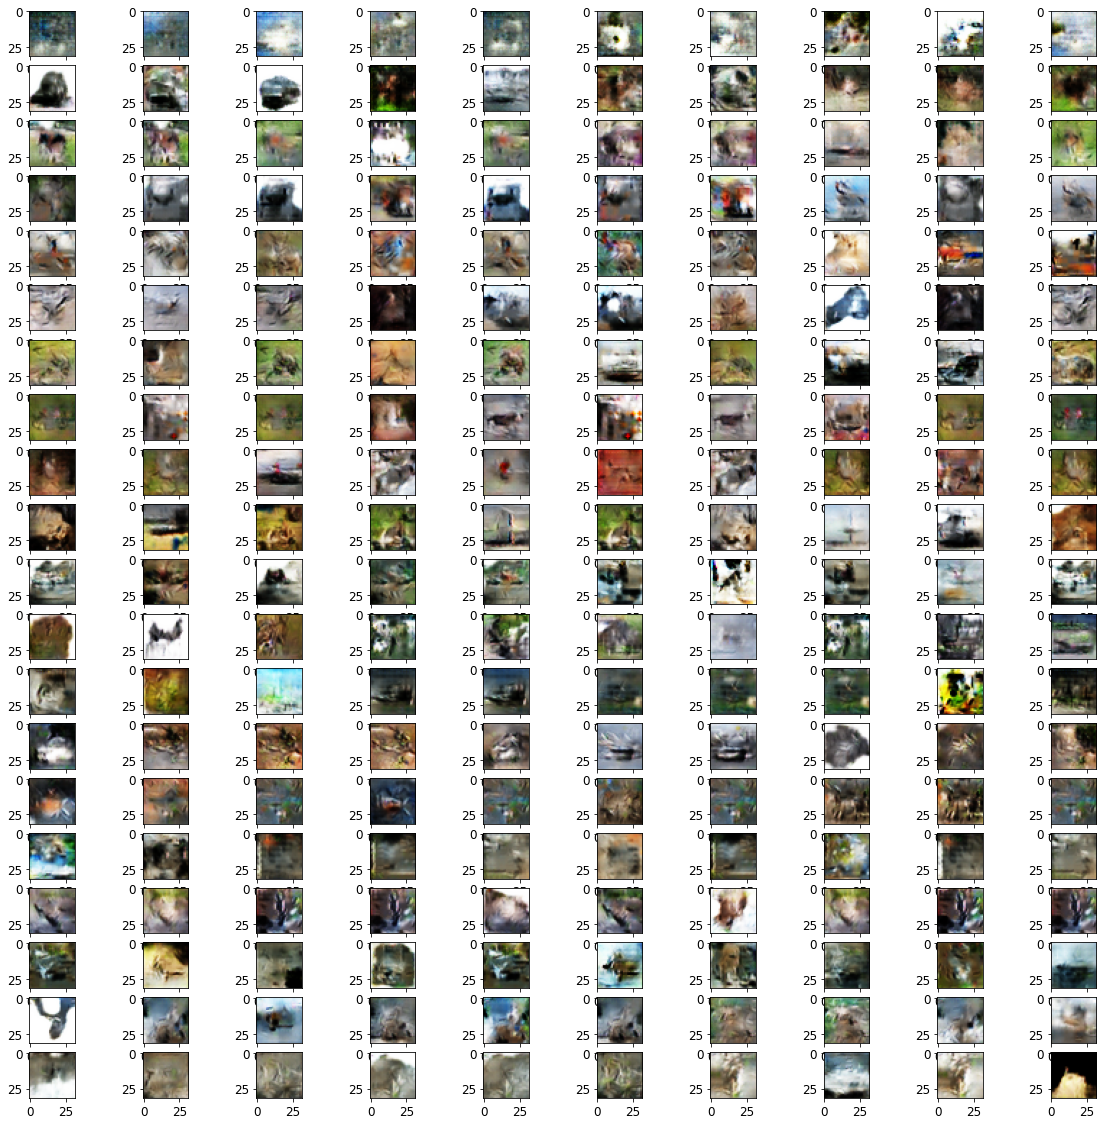

In [13]:
sample_list = []

for weights in dcgan_100_history.weights:
    dcgan_100.set_weights(weights)
    sample_list.append((dcgan_100.sample(n_samples=10) + 1.) / 2.)

samples = tf.concat(sample_list, axis=0)
display_samples(samples)

In [14]:
dcgan_200_history = ModelSnapshotter(5)
dcgan_200 = DCGAN(200)
dcgan_200.compile(optimizer="rmsprop")
dcgan_200.fit(
    train_dataset, 
    epochs=100,
    callbacks=[
        get_tensorboard_cb(), 
        dcgan_200_history,
        # keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ])

Epoch 1/100
1563/1563 [==============================] - 42s 26ms/step - disc_loss: 0.7286 - gen_loss: 1.1303
Epoch 2/100
1563/1563 [==============================] - 41s 26ms/step - disc_loss: 0.6866 - gen_loss: 0.8973
Epoch 3/100
1563/1563 [==============================] - 41s 26ms/step - disc_loss: 0.6214 - gen_loss: 1.2711
Epoch 4/100
1563/1563 [==============================] - 41s 26ms/step - disc_loss: 0.5552 - gen_loss: 1.6065
Epoch 5/100
1563/1563 [==============================] - 41s 26ms/step - disc_loss: 0.5088 - gen_loss: 1.8734
Epoch 6/100
1563/1563 [==============================] - 41s 26ms/step - disc_loss: 0.5004 - gen_loss: 1.9617
Epoch 7/100
1563/1563 [==============================] - 41s 26ms/step - disc_loss: 0.4944 - gen_loss: 2.0394
Epoch 8/100
1563/1563 [==============================] - 41s 26ms/step - disc_loss: 0.5184 - gen_loss: 1.9489
Epoch 9/100
1563/1563 [==============================] - 41s 26ms/step - disc_loss: 0.5033 - gen_loss: 2.1188
Epoch 10/1

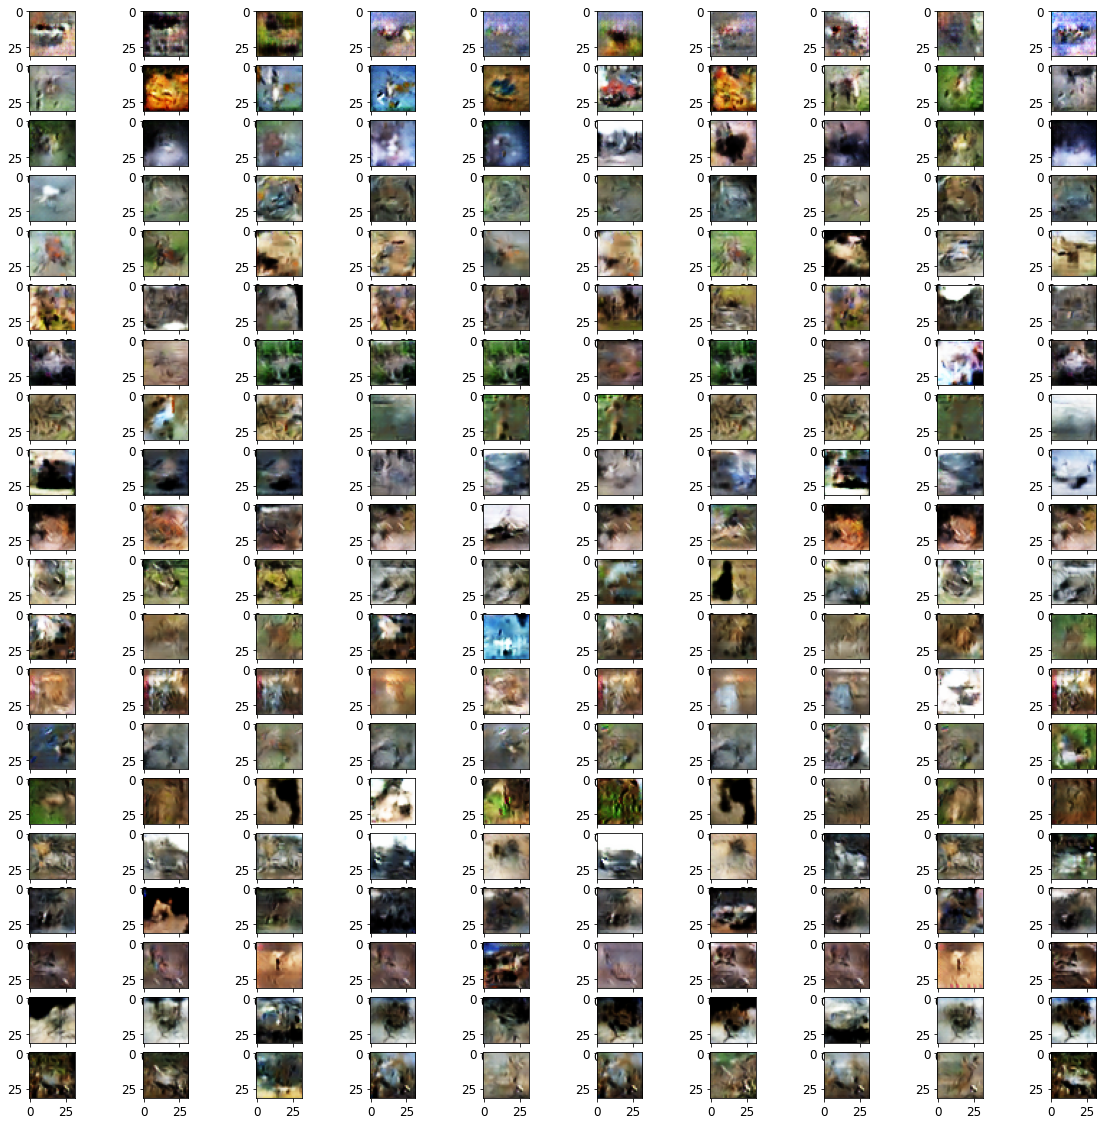

In [16]:
sample_list = []

for weights in dcgan_200_history.weights:
    dcgan_200.set_weights(weights)
    sample_list.append((dcgan_200.sample(n_samples=10) + 1.) / 2.)

samples = tf.concat(sample_list, axis=0)
display_samples(samples)

In [98]:
tf.math.count_nonzero(tf.Variable([True, False]))

<tf.Tensor: shape=(), dtype=int64, numpy=1>

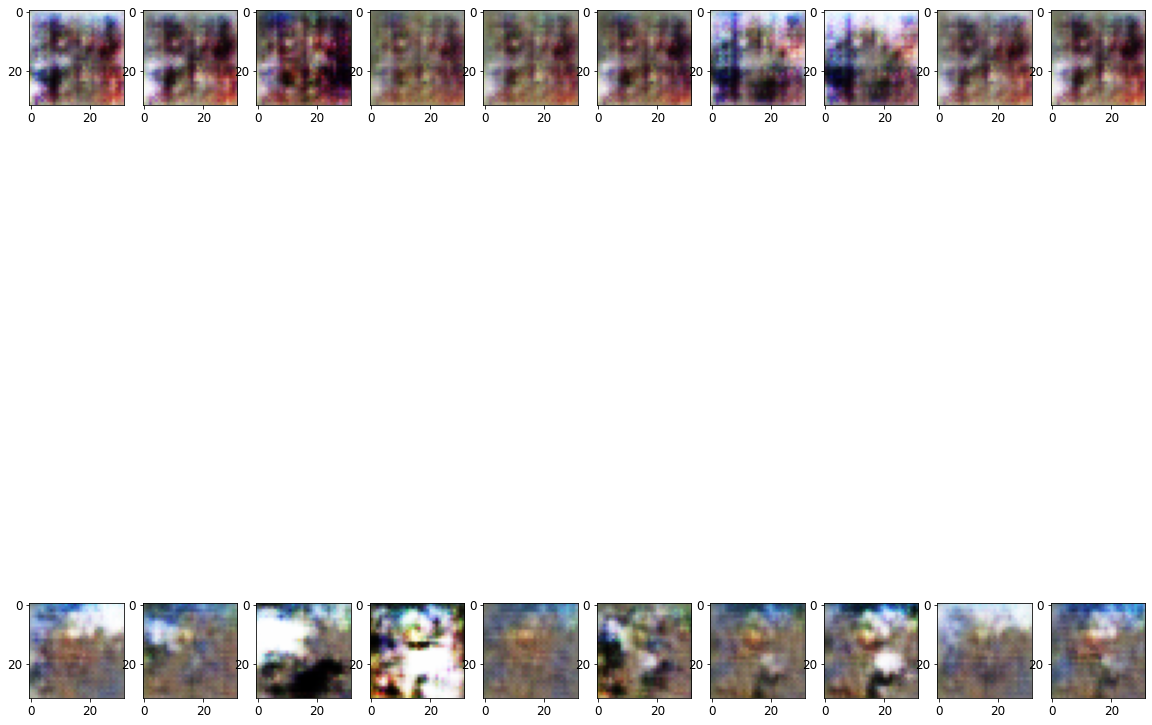

In [53]:
sample_list = []

for weights in dcgan_200_experience_history.weights:
    dcgan_200_experience.set_weights(weights)
    sample_list.append((dcgan_200_experience.sample(n_samples=10) + 1.) / 2.)

samples = tf.concat(sample_list, axis=0)
display_samples(samples)